In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from html import unescape
import spacy
import nltk

from nltk.stem.snowball import SnowballStemmer

import pickle 


In [4]:
pronoun_in_consideration = 'you'

### Load country-continent data 

In [5]:
# https://www.kaggle.com/datasets/alexeyblinnikov/country-adjective-pairs?resource=download
# https://github.com/dbouquin/IS_608/blob/master/NanosatDB_munging/Countries-Continents.csv

country_continent = pd.read_csv("data/Countries-Continents.txt")
country_adjective_pair = pd.read_csv("data/demonyms.csv", names=['adjective', 'country_name'])
country_adjective_pair = dict(zip(country_adjective_pair['country_name'], country_adjective_pair['adjective']))
country_continent['country_adjective'] = country_continent['Country'].apply(
    lambda x: country_adjective_pair[x] if x in country_adjective_pair.keys() else pd.NA
)

country_continent = country_continent.dropna()


print(country_continent.shape)

(179, 3)


Define sentiment classes for "you"

In [6]:
you_sentiment_classes = ['casual_you', 'formal_you']

def contain_casual_you(sentence):
    return 1 if "du" in sentence.lower().split() else 0

def contain_formal_you(sentence):
    return 1 if "sie" in sentence.lower().split() else 0

In [7]:
def extract_country(country_df, sentence):
    sentence_countries = []
    country_names = country_df['Country'].values.tolist()
    country_adjs = country_df['country_adjective'].values.tolist()
    splitted = nltk.word_tokenize(sentence)
    
    for x in splitted:
        if x in country_names:
            sentence_countries.append((x, 'country_name'))
        elif x in country_adjs:
            sentence_countries.append((x, 'country_adjective'))
    return sentence_countries

In [14]:
if pronoun_in_consideration == 'he':
    sentiment_classes = he_sentiment_classes
elif pronoun_in_consideration == 'she':
    sentiment_classes = she_sentiment_classes
elif pronoun_in_consideration == 'you':
    sentiment_classes = you_sentiment_classes
else:
    raise RuntimeError("Unknown pronoun")

# Replacing countries to create input samples

Covost2 EN sentences chosen (taken from the fr-en dataset), as we do not need REF, and Covost sentences are short

In [8]:
# Code taken from https://en.wikibooks.org/wiki/Algorithm_Implementation/Strings/Levenshtein_distance#Python
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

Load original SRC data

In [9]:
original_data = pd.DataFrame()
original_data['SRC'] = pd.read_csv("data/covost2/covost_v2.fr_en.tsv", sep='\t')['translation']
print(original_data.shape)

# original_data['countries'] = original_data['SRC'].apply(lambda x: extract_country(country_continent, x))
# original_data.to_pickle("data/covost2/countries_tagged.tsv")

original_data = pd.read_pickle("data/covost2/countries_tagged.tsv")

# Filter out sentences with country and the pronoun_in_consideration
original_data = original_data[original_data['countries'].apply(lambda x: True if len(x) == 1 else False) & \
                              original_data['SRC'].apply(lambda x: True if pronoun_in_consideration in x.lower().split() else False)]

print(original_data.shape)

original_data.head()


(264897, 1)
(134, 2)


,SRC,countries
2871,Have you ever submitted a petition to the Germ...,"[(German, country_adjective)]"
9908,Have you ever been in Thailand?,"[(Thailand, country_name)]"
13283,Have you ever been in Thailand?,"[(Thailand, country_name)]"
21751,You are Germany.,"[(Germany, country_name)]"
22825,You can find one on Canada’s national flag.,"[(Canada, country_name)]"


### Create a dataset for input
Replace different countries to create a dataset

In [10]:
# dataset = pd.DataFrame(columns=["SRC", "continent", "race", "country"])

# for i1, original_row in original_data.iterrows():
#     for i2, country_row in country_continent.iterrows():
#         for original_country in original_row['countries']:
#             if original_country[1] == 'country_name':
#                 dataset = dataset.append({"SRC": original_row['SRC'].replace(original_country[0], country_row['Country']),
#                                           "continent": country_row['Continent'],
#                                           "race": 'white' if country_row['Continent'] in ['Europe', 'North America', 'South America', 'Oceania'] else 'non-white',
#                                           "country": country_row['Country']},
#                                          ignore_index=True)
#             elif original_country[1] == 'country_adjective':
#                 dataset = dataset.append({"SRC": original_row['SRC'].replace(original_country[0], country_row['country_adjective']),
#                                           "continent": country_row['Continent'],
#                                           "race": 'white' if country_row['Continent'] in ['Europe', 'North America', 'South America', 'Oceania'] else 'non-white',
#                                           "country": country_row['country_adjective']},
#                                          ignore_index=True)


# dataset.to_csv(f"data/covost2/covost2_countries_replacement_{pronoun_in_consideration}.csv")
    
# dataset.shape

(23986, 4)

### Analyse the translation

In [16]:
translation = pd.read_csv(f"output/covost2_countries_replacement_{pronoun_in_consideration}/masking_language_model/beam5_perturbNone/seed0/translations.csv",
                          index_col=0)

# Include index

translation['SRC_index'] = np.repeat(original_data.index.values, country_continent.shape[0])
translation["is_original"] = translation.apply(lambda x: x['country'] in original_data.loc[x['SRC_index']]['SRC'], axis=1)
original_trans = translation[translation["is_original"]].copy()
translation.rename({'OriginalSRC-Trans': 'Perturbed-Country-Trans'}, axis='columns', inplace=True)
translation = translation.merge(original_trans[['SRC_index', 'OriginalSRC-Trans']], how='left', on='SRC_index')

# Convert country column to consistent form 
country_adj_dict = dict(zip(country_continent['country_adjective'].values, country_continent['Country'].values))
translation['country'] = translation['country'].apply(lambda x: x if x not in country_adj_dict.keys() else country_adj_dict[x])


translation['Trans-edit_distance'] =  translation.apply(
            lambda x: levenshtein(nltk.word_tokenize(x['OriginalSRC-Trans']), nltk.word_tokenize(x["Perturbed-Country-Trans"])), axis=1)

if pronoun_in_consideration == 'he':
    translation['negative_he'] = translation['Perturbed-Country-Trans'].apply(lambda x: contain_negative_he(x))
    translation['semi_negative_he'] = translation['Perturbed-Country-Trans'].apply(lambda x: contain_semi_negative_he(x))
    translation['neutral_he'] = translation['Perturbed-Country-Trans'].apply(lambda x: contain_neutral_he(x))
elif pronoun_in_consideration == 'she':
    translation['negative_she'] = translation['Perturbed-Country-Trans'].apply(lambda x: contain_negative_she(x))
    translation['semi_negative_she'] = translation['Perturbed-Country-Trans'].apply(lambda x: contain_semi_negative_she(x))
    translation['neutral_she'] = translation['Perturbed-Country-Trans'].apply(lambda x: contain_neutral_she(x))
elif pronoun_in_consideration == 'you':
    translation['casual_you'] = translation['Perturbed-Country-Trans'].apply(lambda x: contain_casual_you(x))
    translation['formal_you'] = translation['Perturbed-Country-Trans'].apply(lambda x: contain_formal_you(x))

sentiment_class_white = {}
for sentiment_class in sentiment_classes:
    sentiment_class_white[sentiment_class] = \
                ((translation[sentiment_class] == 1) & (translation['race'] == 'white')).sum()
# Normalize the counts
sentiment_class_white = {k: v/sum(sentiment_class_white.values()) for k, v in sentiment_class_white.items()}


sentiment_class_nonwhite = {}
for sentiment_class in sentiment_classes:
    sentiment_class_nonwhite[sentiment_class] = \
                ((translation[sentiment_class] == 1) & (translation['race'] == 'non-white')).sum()
# Normalize the counts
sentiment_class_nonwhite = {k: v/sum(sentiment_class_nonwhite.values()) for k, v in sentiment_class_nonwhite.items()}

print(sentiment_class_white)
print(sentiment_class_nonwhite)



{'casual_you': 0.00018745899334520573, 'formal_you': 0.9998125410066548}
{'casual_you': 0.0, 'formal_you': 1.0}


In [19]:
def calculate_sentiment_per_country(df, sentiment_classes):
    count_sentiment_0 = df[sentiment_classes[0]].sum()
    count_sentiment_1 = df[sentiment_classes[1]].sum()
    
    sum_all = count_sentiment_0 + count_sentiment_1
    
    return df['country'].values.tolist()[0], count_sentiment_0/sum_all, count_sentiment_1/sum_all

    
analyse_df = pd.DataFrame()
    
analyse_df['country'], analyse_df[f"{sentiment_classes[0]}_portion"], analyse_df[f"{sentiment_classes[1]}_portion"]\
    = zip(*translation.groupby(by="country", group_keys=True).apply(lambda x: calculate_sentiment_per_country(x, sentiment_classes)))


analyse_df = analyse_df.merge(country_continent[['Country', 'Continent']], left_on='country', right_on='Country').drop('Country', axis=1)

analyse_df.head()


,country,casual_you_portion,formal_you_portion,Continent
0,Afghanistan,0.0,1.0,Asia
1,Albania,0.0,1.0,Europe
2,Algeria,0.0,1.0,Africa
3,Andorra,0.0,1.0,Europe
4,Angola,0.0,1.0,Africa


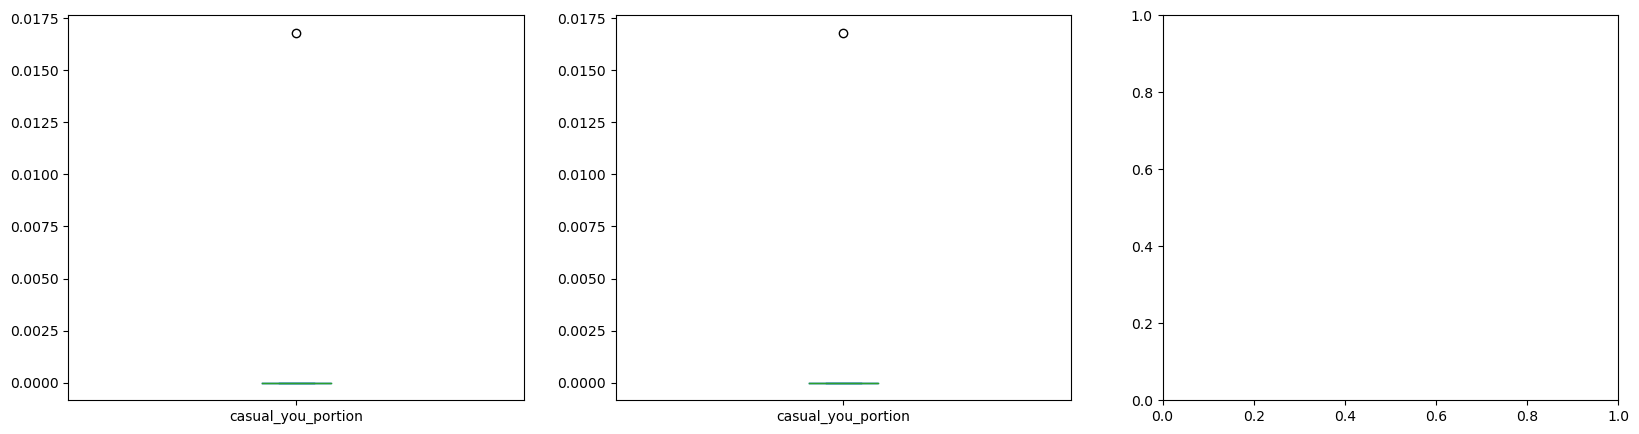

In [20]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

for i, sentiment_class in enumerate(sentiment_classes):
    analyse_df[f"casual_you_portion"].plot.box(ax=axes[i])


In [21]:
analyse_df[analyse_df[f'casual_you_portion'] > 0.55]

,country,casual_you_portion,formal_you_portion,Continent


#### In terms of general changes:

Sometimes the end part of the sentence is not translated???

In [22]:
translation.sort_values(by='Trans-edit_distance', ascending=False).head()

,SRC_index,SRC,continent,race,country,Perturbed-Country-Trans,is_original,OriginalSRC-Trans,Trans-edit_distance,casual_you,formal_you
11494,213862,You can find one on Sierra Leone’s national flag.,Africa,non-white,Sierra Leone,Auf der Nationalflagge von Sierra Leone ist ei...,False,Man findet sie auf Kanadas Nationalflagge.,10,0,0
12926,229145,You can find one on Sierra Leone’s national flag.,Africa,non-white,Sierra Leone,Auf der Nationalflagge von Sierra Leone ist ei...,False,Man findet sie auf Kanadas Nationalflagge.,10,0,0
8809,178633,You can’t seriously sell Sierra Leonean salmon...,Africa,non-white,Sierra Leone,In Hessen kann man Lachs aus Sierra Leone nich...,False,Norwegischer Lachs kann in Hessen nicht ernsth...,10,0,0
23129,347486,You can’t seriously sell Sierra Leonean salmon...,Africa,non-white,Sierra Leone,In Hessen kann man Lachs aus Sierra Leone nich...,False,Norwegischer Lachs kann in Hessen nicht ernsth...,10,0,0
754,22825,You can find one on Sierra Leone’s national flag.,Africa,non-white,Sierra Leone,Auf der Nationalflagge von Sierra Leone ist ei...,False,Man findet sie auf Kanadas Nationalflagge.,10,0,0


**Note**: Domain changed with covost


### Sentiment portion vs continent

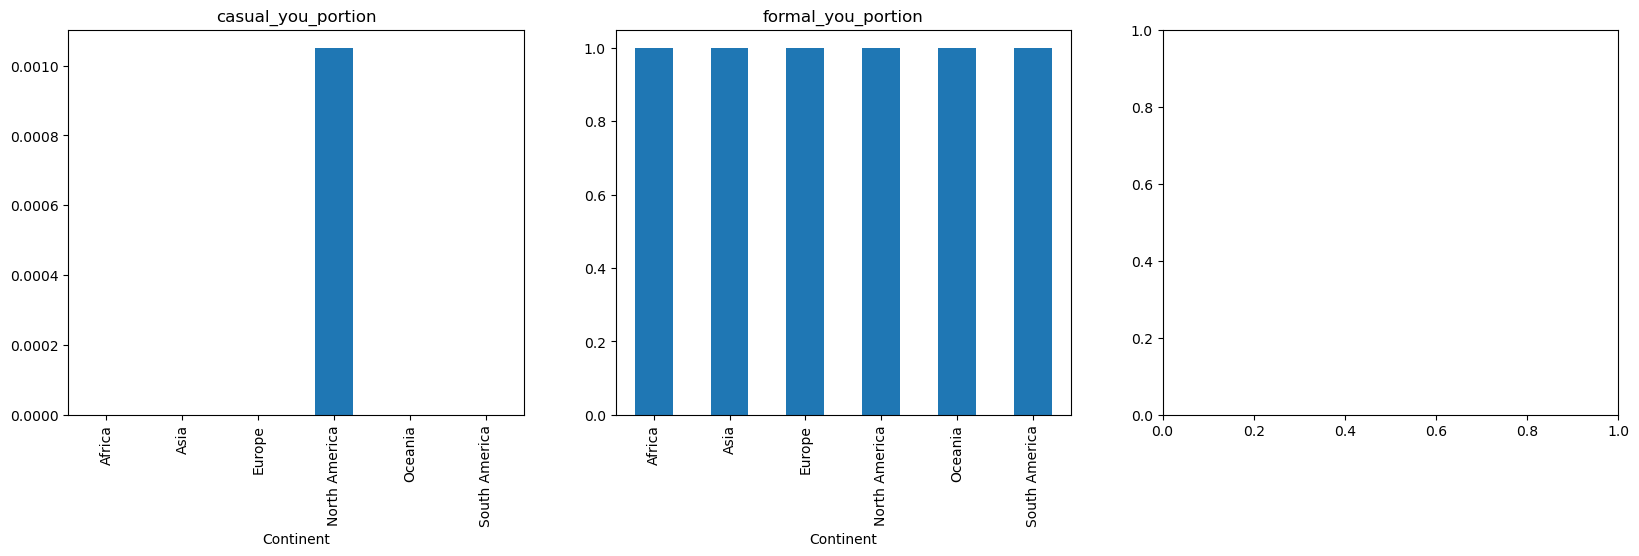

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

for i, sentiment_class in enumerate(sentiment_classes):
    analyse_df.groupby('Continent').mean()[f'{sentiment_class}_portion'].plot.bar(ax=axes[i], title=f'{sentiment_class}_portion')



### Sentiment portion vs economy (gdp per capita)

In [24]:
# https://data.worldbank.org/indicator/NY.GDP.PCAP.CD
import math

country_gdp_per_capita = pd.read_csv("data/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_4666475/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_4666475.csv").drop('Unnamed: 66', axis=1).dropna(axis=0, how='all')


country_gdp_per_capita_latest = []
no_value_indices = []

for index, row in country_gdp_per_capita.iterrows():
    gdp_values = row.values
    found = False
    for value in reversed(gdp_values):
        if not isinstance(value, float):
            break
        if not math.isnan(value):
            country_gdp_per_capita_latest.append(value)
            found = True
            break
    if not found:
        no_value_indices.append(index)
        
        

country_gdp_per_capita.drop(no_value_indices, axis=0, inplace=True)
            
country_gdp_per_capita_latest = pd.DataFrame({'Country': country_gdp_per_capita['Country Name'].values, 
                                              'Latest-GDP-per-capita': country_gdp_per_capita_latest})


country_gdp_per_capita_latest.head()


,Country,Latest-GDP-per-capita
0,Aruba,23384.298791
1,Africa Eastern and Southern,1557.722682
2,Afghanistan,516.747871
3,Africa Western and Central,1774.921218
4,Angola,2137.909393


<AxesSubplot:xlabel='Latest-GDP-per-capita', ylabel='casual_you_portion'>

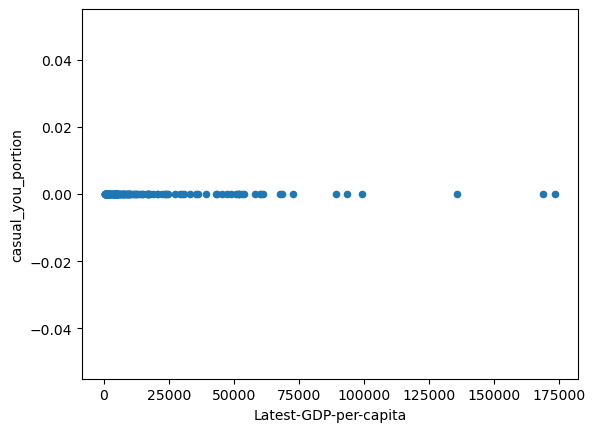

In [25]:
pd.merge(country_gdp_per_capita_latest, 
         analyse_df, 
         how='inner', 
         left_on='Country', 
         right_on='country').plot.scatter(x='Latest-GDP-per-capita', y=f'casual_you_portion')
